In [2]:
# %matplotlib inline
import sys
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from collections import OrderedDict
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp

import rubin_sim.maf.db as db
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.metric_bundles as metric_bundles
from rubin_sim.maf.metric_bundles import MetricBundleGroup
from rubin_sim.maf.utils import m52snr
from rubin_sim.maf.plots import HealpixSkyMap
from rubin_sim.phot_utils import DustValues
import sys
import os
# Add current script's directory to sys.path
sys.path.append("/Users/andradenebula/Documents/Research/Transient_Metrics/Multi_Transient_Metrics_Hub")
from shared_utils import inject_uniform_healpix






In [7]:
import importlib


# Clear the module from cache
if "local_ShockCoolingType2b_metric" in sys.modules:
    del sys.modules["local_ShockCoolingType2b_metric"]

# Re-import and reload the updated module
import local_ShockCoolingType2b_metric
importlib.reload(local_ShockCoolingType2b_metric)

# Confirm path
print(local_ShockCoolingType2b_metric.__file__)
from local_ShockCoolingType2b_metric import (
    ShockCoolingLC,
    ShockCoolingDetectMetric,
    ShockCoolingCharacterizeMetric,
    ShockCoolingDoublePeakMetric,
    generateShockCoolingPopSlicer,
    plot_shockcooling_population_summary
)
# Clear the module from cache
if "shared_utils" in sys.modules:
    del sys.modules["shared_utils"]
import shared_utils 
importlib.reload(shared_utils)


/Users/andradenebula/Documents/Research/Transient_Metrics/Multi_Transient_Metrics_Hub/ShockCooling/local_ShockCoolingType2b_metric.py


<module 'shared_utils' from '/Users/andradenebula/Documents/Research/Transient_Metrics/Multi_Transient_Metrics_Hub/shared_utils.py'>

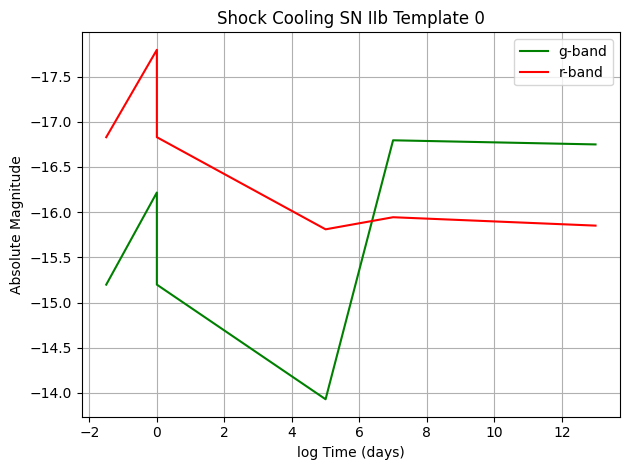

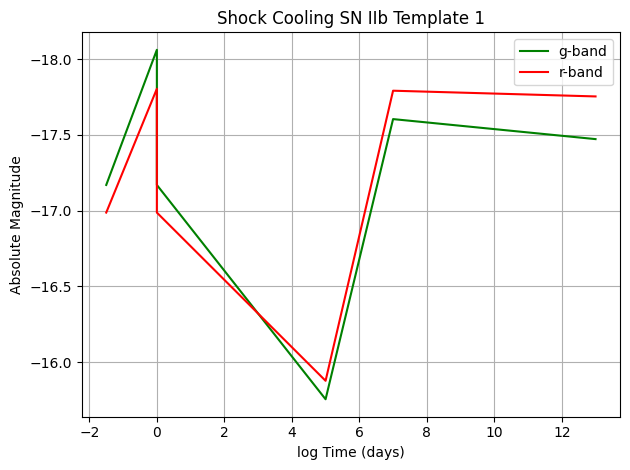

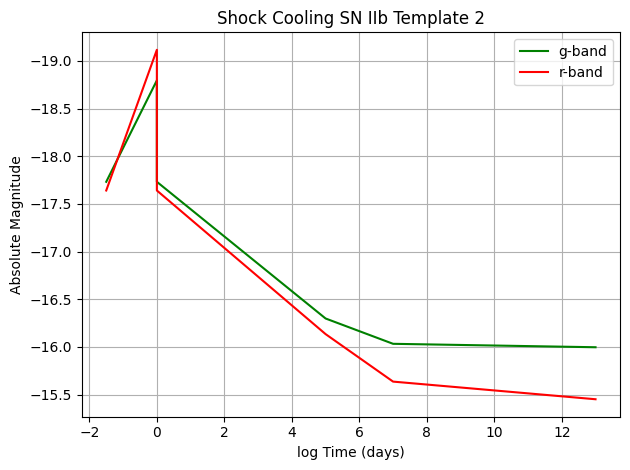

In [62]:


# Load pre-generated Shock Cooling light curve templates
with open("ShockCooling_templates.pkl", "rb") as f:
    lcdict = pickle.load(f)

lightcurves = lcdict["lightcurves"]

# Plot 3 sample light curves in g and r
for i in range(3):
    for band, color in zip(['g', 'r'], ['green', 'red']):
        ph = lightcurves[i][band]['ph']
        mag = lightcurves[i][band]['mag']
        plt.plot((ph + 1e-5), mag, label=f'{band}-band', color=color)

    plt.xlabel("log Time (days)")
    plt.ylabel("Absolute Magnitude")
    plt.title(f"Shock Cooling SN IIb Template {i}")
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [5]:
# --------------------------------------------
# Configuration
# --------------------------------------------
cadences = ['four_roll_v4.3.1_10yrs', 'baseline_v4.3.1_10yrs']
filters = ['g', 'r']
db_dir = "../"
t_start = 1
t_end = 3652
rate_per_year = 65000
dmin = 10
dmax = 300
grbs_dir = "ShockCooling_output/fixedpop/"
template_file = "ShockCooling_templates.pkl"
pop_file = os.path.join(grbs_dir, "ShockCooling_population_fixed.pkl")
os.makedirs(grbs_dir, exist_ok=True)

# --------------------------------------------
# Template Setup
# --------------------------------------------
if not os.path.exists(template_file):
    ShockCoolingLC()  # Will auto-generate and save
shared_lc_model = ShockCoolingLC(load_from=template_file)

# --------------------------------------------
# Population Setup
# --------------------------------------------
if not os.path.exists(pop_file):
    
    slicer = generateShockCoolingPopSlicer(
        t_start=t_start, t_end=t_end,
        d_min=dmin, d_max=dmax,
        rate_per_year=rate_per_year,
        seed=42,
        save_to=pop_file
    )

else:
    with open(pop_file, 'rb') as f:
        slice_data = pickle.load(f)
    slicer = slicers.UserPointsSlicer(ra=slice_data['ra'], dec=slice_data['dec'], badval=0)
    slicer.slice_points.update(slice_data)

n_events = len(slicer.slice_points['distance'])

# --------------------------------------------
# Main Execution Loop
# --------------------------------------------
first = True
for cadence in cadences:
    runName = cadence
    opsdb = os.path.join(db_dir, f"{cadence}.db")
    outDir = os.path.join(grbs_dir, f"Metric_temp_{cadence}")
    os.makedirs(outDir, exist_ok=True)
    resultsDb = db.ResultsDb(out_dir=outDir)

    print(f"\n--- Running {cadence} ---")

    # ----------------------------------------
    # Detection
    # ----------------------------------------
    detect_metric = ShockCoolingDetectMetric(metricName="ShockCooling_Detect", lc_model=shared_lc_model)
    detect_bundle = metric_bundles.MetricBundle(detect_metric, slicer, '', plot_funcs=[], summary_metrics=[metrics.SumMetric()])
    detect_group = metric_bundles.MetricBundleGroup({'ShockCooling_Detect': detect_bundle}, opsdb, out_dir=outDir, results_db=resultsDb)
    detect_group.run_all()

    detected_flags = (detect_bundle.metric_values == 1) & (~detect_bundle.metric_values.mask)
    n_detected = np.sum(detected_flags)

    print(f"Out of {n_events} simulated Shock Cooling events, Rubin detected {n_detected} under {cadence}.")

    # ----------------------------------------
    # Characterization (only if detected)
    # ----------------------------------------
    char_metric = ShockCoolingCharacterizeMetric(metricName="ShockCooling_Characterize", lc_model=shared_lc_model)
    char_bundle = metric_bundles.MetricBundle(char_metric, slicer, '', plot_funcs=[], summary_metrics=[metrics.SumMetric()])
    char_group = metric_bundles.MetricBundleGroup({'ShockCooling_Characterize': char_bundle}, opsdb, out_dir=outDir, results_db=resultsDb)
    char_group.run_all()

    # ----------------------------------------
    # Double Peak Detection
    # ----------------------------------------
    dp_metric = ShockCoolingDoublePeakMetric(metricName="ShockCooling_DoublePeak", lc_model=shared_lc_model)
    dp_bundle = metric_bundles.MetricBundle(dp_metric, slicer, '', plot_funcs=[], summary_metrics=[metrics.SumMetric()])
    dp_group = metric_bundles.MetricBundleGroup({'ShockCooling_DoublePeak': dp_bundle}, opsdb, out_dir=outDir, results_db=resultsDb)
    dp_group.run_all()

    # ----------------------------------------
    # Healpix Sky Map Plot
    # ----------------------------------------
    nside = slicer.slice_points['nside'] if 'nside' in slicer.slice_points else 64
    npix = hp.nside2npix(nside)

    injected_map = np.zeros(npix)
    detected_map = np.zeros(npix)

    ra_rad = slicer.slice_points['ra']
    dec_rad = slicer.slice_points['dec']
    theta = 0.5 * np.pi - dec_rad
    phi = ra_rad
    pix_inds = hp.ang2pix(nside, theta, phi)

    for i, pix in enumerate(pix_inds):
        injected_map[pix] += 1
        if detect_bundle.metric_values[i] == 1:
            detected_map[pix] += 1

    eff_map = np.zeros(npix)
    mask = injected_map > 0
    eff_map[mask] = detected_map[mask] / injected_map[mask]
    eff_map[~mask] = hp.UNSEEN

    hp.mollview(eff_map, title=f"{runName} – Shock Cooling Detection Efficiency", unit='Efficiency', cmap='viridis')
    hp.graticule()
    plt.show()

    # ----------------------------------------
    # Summary Table
    # ----------------------------------------
    if first:
        df = pd.DataFrame({
            "run": [runName],
            "n_detected": [n_detected],
            "n_total": [n_events]
        })
        first = False
    else:
        df = pd.concat([df, pd.DataFrame({
            "run": [runName],
            "n_detected": [n_detected],
            "n_total": [n_events]
        })])

# Save final summary
df.to_csv(os.path.join(grbs_dir, "shockcooling_summary.csv"), index=False)
print("Saved summary to shockcooling_summary.csv")

Loaded 100 shock cooling light curves from ShockCooling_templates.pkl

--- Running four_roll_v4.3.1_10yrs ---


/opt/anaconda3/envs/rubin_sim_223/lib/python3.11/site-packages/rubin_sim/maf/maps/dust_map.py:46: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


KeyboardInterrupt: 